# Preparations

In [1]:
# Env
from Env2_Stable_Volatile_Bandit import *
from Agent import *

/Users/Marvin/opt/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Save Paths
from datetime import datetime
path = "../Log/train_env2/" + datetime.now().strftime("%m%d-%H:%M:%S")

In [3]:
# Hyperparameters
# an entropy cost linearly decreasing from 1 to 0
gamma = 0.1  # Discount factor for past rewards
learning_rate = 1e-5

# Hyperparameters
beta_v = 0.05
beta_e = 0.05

# train
nb_trials = 200
nb_episodes = 40000

In [4]:
env = Stable_Volatile_Bandit()

agent = Agent(learning_rate, gamma, beta_v, beta_e,  #loss func
                 env, nb_trials, nb_episodes,  #train
                 path)

2023-01-09 23:50:13.596760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Training

In [5]:
agent.train()

In [ ]:
# agent.model.save(path+'/model.h5')

# Testing

In [5]:
test_model = keras.models.load_model('../Log/train_env2/0109-12:37:29/model.h5')
#test_model = model
test_episode = 1

In [21]:
test_summary_writer = tf.summary.create_file_writer(agent.test_dir)
l_rate_history = []
agent.env.training = False
agent.env.state == VOLATILE_FIRST

for episode in range(test_episode):
    if(agent.env.nb_obs>0):
        obs = agent.env.test_reset()
    else: 
        agent.env.test_reset()
        obs = []
    
    action_probs_history = []
    rewards_history = []
    critic_value_history = []
    reward = 0.0
    action_onehot = np.zeros((agent.nb_actions))
    cell_state = [tf.zeros((1,agent.nb_hidden)),tf.zeros((1,agent.nb_hidden))]
    entropy = 0.0
    
    for timestep in range(nb_trials * agent.action_per_trial):
        
        input = np.concatenate((obs, action_onehot, [reward], [timestep]),dtype = np.float32)
        input = tf.expand_dims(input,0)
        
        # Predict action probabilities and estimated future rewards from environment state
        action_probs, critic_value, cell_state = test_model([input,cell_state[0],cell_state[1]])
        critic_value_history.append(tf.squeeze(critic_value))
        
        # Sample action from action probability distribution
        action_probs = tf.squeeze(action_probs)
        action = np.random.choice(agent.nb_actions, p=action_probs.numpy())
        action_probs_history.append(action_probs[action])
        action_onehot = np.zeros((agent.nb_actions))
        action_onehot[action] = 1.0

        # Apply the sampled action in our environment
        if(agent.env.nb_obs>0):   
            obs, reward, done, _ = agent.env.trial(action)
        else: reward, done, _ = agent.env.trial(action)
        rewards_history.append(reward)
        
        # entropy
        entropy += sp.stats.entropy(action_probs)
        
        if done: break

    with test_summary_writer.as_default():
        tf.summary.scalar('loss/entropy', entropy, step=episode)
        tf.summary.scalar('game/reward', np.sum(rewards_history), step=episode)
        tf.summary.histogram('game/action_probs', action_probs_history, step=episode)

for i in range(1,len(rewards_history)-1):
    v_0 = critic_value_history[i-1]
    v_2 = critic_value_history[i+1]
    v_1 = critic_value_history[i]
    r = rewards_history[i]
    rpe = r + agent.gamma * v_2 - v_1
    
    l_rate = (v_2 - v_1) / rpe
    l_rate_history.append(l_rate)
    


# Analysis

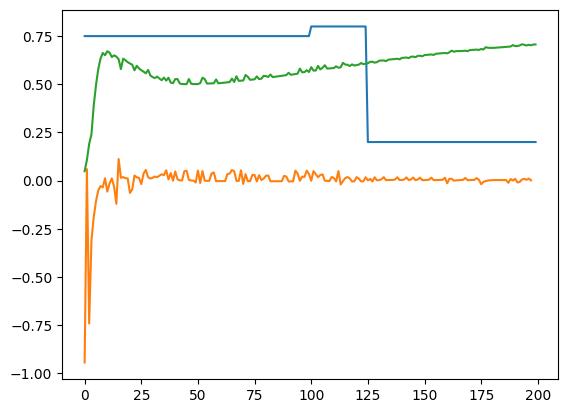

In [22]:
import matplotlib.pyplot as plt

plt.plot(agent.env.get_proba_history())
plt.plot(l_rate_history)
plt.plot(critic_value_history)
plt.show()